<a href="https://colab.research.google.com/github/bjkeulen/TM10007_PROJECT/blob/master/TM10007_Assignment_Group_12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classifying Head and Neck cancer tumour stages using Machine Learning Classifiers
## TM10007 Machine Learning

Luuk Bolhuis (4392116)

Arthur van Nieuw Amerongen (4545257)

Fenne van der Zwaard (4434978)

Bart Keulen (4431413)

In [0]:
# Run this to use from colab environment
!pip install -q --upgrade git+https://github.com/bjkeulen/TM10007_PROJECT

##Packages

In [0]:
# General packages
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn import model_selection
from sklearn import feature_selection 
from sklearn import preprocessing
from sklearn.decomposition import PCA
from scipy.stats import shapiro

# Data loading
from hn.load_data import load_data

# Classifiers
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC

## Data loading and cleaning

In [0]:
# Extract features and labels
data = load_data()
features = data.drop('label', 1)
label = data['label']

print(f'The number of samples of raw data: {len(features.index)}')
print(f'The number of features of raw data: {len(features.columns)}')

# Binarize labels of tumor stadia
label[label=='T12'] = 0
label[label=='T34'] = 1
label = label.astype(int)

# Delete features with missing data
features.dropna(axis=1)

# Testing for normal distribution using Shapiro-Wilk test --> Moet dit hier of ergens anders?
shap_wilk = []
for col in features.columns:
    shap_wilk.append(shapiro(features[col])[1])
print(f'\nShapiro-Wilk test for normal distribution of features: {all(val<=0.05 for val in shap_wilk)}')

The number of samples of raw data: 113
The number of features of raw data: 159

Shapiro-Wilk test for normal distribution of features: False


## Initializing classifiers

In [0]:
# Create list with the classifiers that will be trained and tested
clsfs = []
col_names = []
kernels = ['linear', 'rbf', 'sigmoid']
for kernel in kernels:
    clsfs.append(SVC(kernel=kernel))
    col_names.append(f'SVM {kernel} C=')

clsfs.extend([SVC(kernel='poly'), RandomForestClassifier(), KNeighborsClassifier(), RidgeClassifier(), LinearDiscriminantAnalysis(), 
          QuadraticDiscriminantAnalysis(), GaussianNB(), LogisticRegression(), SGDClassifier()])
col_names.extend(['SVM poly d=', 'RF n=', 'KNN k=', 'Ridge a=', 'LDA', 'QDA', 'Gaussian NB', 'Log Regression', 'SGDC'])
  
# Parameters for parameter estimation in grid search
parameters = [{'C': list(np.logspace(-2, 0, 200))}, # SVM linear
              {'C': list(np.logspace(-2, 0, 200))}, # SVM rbf
              {'C': list(np.logspace(-2, 0, 200))}, # SVM sigmoid 
              {'degree': list(range(1, 10)), 'C': list(np.logspace(-2, 0, 200))}, # SVM poly
              {'n_estimators': list(range(5, 200, 5))}, # Random Forest
              {'n_neighbors': list(range(1, 30))}, # k-Nearest Neighbour
              {'alpha': list(np.logspace(-10, 2, 200))}] # Ridge Regression (L2 penalty)

##Cross-validation

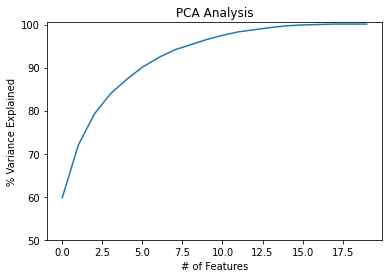

Amount of features accounting for 95% of the variance in the data: 9


In [0]:
# Split data into 10 folds for the outer cross-validation
amount_folds = 10
cv_10fold = model_selection.StratifiedKFold(n_splits=amount_folds, shuffle=True)

fold_N = 1
for design_index, test_index in cv_10fold.split(features, label):
    # Creating design and test set
    feat_design = features.iloc[design_index]
    label_design = label.iloc[design_index]

    feat_test = features.iloc[test_index]
    label_test = label.iloc[test_index]

    # Scaling
    scaler_robust = preprocessing.RobustScaler()
    scaler_robust.fit(feat_design)
    feat_design_scaled = scaler_robust.transform(feat_design)
    feat_test_scaled = scaler_robust.transform(feat_test)

    '''Choose one of the three feature recution methods below by adding or removing the #s'''

    # # Method 1: Feature elimination (selection)
    # rfecv = feature_selection.RFECV(
    #           estimator=SVC(kernel='linear'), step=1, 
    #           cv=model_selection.StratifiedKFold(4),
    #           min_features_to_select=20, # deze moeten we nog bepalen
    #           scoring='accuracy')
    # rfecv.fit(feat_design_scaled, label_design)
    # feat_design_select = rfecv.transform(feat_design_scaled)
    # feat_test_select = rfecv.transform(feat_test_scaled)

    # # Method 2: L1 regularization
    # lsvc = LinearSVC(C=0.1, penalty="l1", dual=False)
    # lsvc = lsvc.fit(feat_design_scaled, label_design)
    # model = feature_selection.SelectFromModel(lsvc, prefit=True)
    # feat_design_select = model.transform(feat_design_scaled)
    # feat_test_select = model.transform(feat_test_scaled)
    
    # Method 3: Univariate testing
    univ_select = feature_selection.GenericUnivariateSelect(
        score_func=feature_selection.f_regression, mode='k_best', param=20)
    univ_select.fit(feat_design_scaled, label_design)
    feat_design_select = univ_select.transform(feat_design_scaled)
    feat_test_select = univ_select.transform(feat_test_scaled)


    if fold_N == 1:
        # Calculate cumulative variance
        covar_matrix = PCA().fit(feat_design_select)
        variance = covar_matrix.explained_variance_ratio_
        var = np.cumsum(np.round(covar_matrix.explained_variance_ratio_, decimals=3))
        n_pca = 1 + next(x for x, val in enumerate(var) if val > 0.95)

        # Plot figure
        plt.ylabel('% Variance Explained')
        plt.xlabel('# of Features')
        plt.title('PCA Analysis')
        plt.ylim(50,100.5)
        plt.style.context('seaborn-whitegrid')
        plt.plot(var*100)
        plt.show()

        print(f'Amount of features accounting for 95% of the variance in the data: {n_pca}')

    # Principal component analysis (PCA)
    p = PCA(n_components=n_pca).fit(feat_design_select)
    feat_design_pca = p.transform(feat_design_select)
    feat_test_pca = p.transform(feat_test_select)

    # Create dataframe to collect performances of each classifier
    index_names = ['Accuracy', 'AUC', 'F1 score', 'Precision', 'Recall']
    performance = pd.DataFrame(index=index_names)
 
    clf_N = 0
    for clf in clsfs:
        if fold_N == 1 and clf_N <= 6:
            # Determine best parameter of the classifier using a grid search based on accuracy
            cv_5fold_grid = model_selection.StratifiedKFold(n_splits=5, shuffle=True)
            grid_search = model_selection.GridSearchCV(clf, parameters[clf_N], cv=cv_5fold_grid, scoring='accuracy')
            grid_search.fit(feat_design_pca, label_design)
            clf = grid_search.best_estimator_
            
            # Predict classes using the best parameter for the classifier
            pred = clf.predict(feat_test_pca)
            
            # Set the parameters for the classifiers to be used in the upcoming folds 
            if clf_N >= 0 and clf_N <= 2: # SVM linear, rbf, sigmoid
                col_names[clf_N] = col_names[clf_N] + str(round(clf.C, 3))
                clsfs[clf_N] = SVC(kernel=kernels[clf_N], C=clf.C)
            elif clf_N == 3: # SVM poly
                col_names[clf_N] = col_names[clf_N] + str(clf.degree) + ', C=' + str(round(clf.C, 3))
                clsfs[clf_N] = SVC(kernel='poly', degree=clf.degree, C=clf.C)
            elif clf_N == 4: # Random Forest
                col_names[clf_N] = col_names[clf_N] + str(clf.n_estimators)
                clsfs[clf_N] = RandomForestClassifier(n_estimators = clf.n_estimators)
            elif clf_N == 5: # k-Nearest Neighbour
                col_names[clf_N] = col_names[clf_N] + str(clf.n_neighbors)
                clsfs[clf_N] = KNeighborsClassifier(n_neighbors = clf.n_neighbors)
            elif clf_N == 6: # Ridge Regression 
                col_names[clf_N] = col_names[clf_N] + str(round(clf.alpha, 3))
                clsfs[clf_N] = RidgeClassifier(alpha = clf.alpha)

        else:
            # Train and test the classifier
            clf = clf
            clf.fit(feat_design_pca, label_design)
            pred = clf.predict(feat_test_pca)

        # Determine probabilities if possible for auc calculation
        if hasattr(clf, 'predict_proba'):
            score = clf.predict_proba(feat_test_pca)[:, 1]
        else:
            score = pred
        
        # Calculate performance metrics
        accuracy = metrics.accuracy_score(label_test, pred)
        auc = metrics.roc_auc_score(label_test, score)
        F1 = metrics.f1_score(label_test, pred)
        precision = metrics.precision_score(label_test, pred)
        recall = metrics.recall_score(label_test, pred)
        
        # Put metrics into performance dataframe and transpose
        performance[col_names[clf_N]] = [accuracy, auc, F1, precision, recall]

        clf_N += 1

    # For fold 1, store measured performances in a new dataframe
    # For fold > 1, add newly measured performances to existing dataframe
    performance = performance.transpose()

    if fold_N == 1:
        performance_concat = performance
    else:
        performance_concat = pd.concat((performance_concat, performance))

    fold_N += 1


##Performance per classifier

Mean of performance
                       Accuracy       AUC  F1 score  Precision    Recall
Gaussian NB            0.671212  0.775000  0.627077   0.727381  0.583333
KNN k=6                0.706061  0.790833  0.663232   0.748333  0.630000
LDA                    0.741667  0.812778  0.736255   0.742381  0.743333
Log Regression         0.732576  0.824444  0.727366   0.722381  0.743333
QDA                    0.689394  0.796111  0.681570   0.699762  0.676667
RF n=55                0.670455  0.759444  0.629495   0.678333  0.593333
Ridge a=21.711         0.741667  0.740000  0.736255   0.742381  0.743333
SGDC                   0.725758  0.718333  0.683651   0.725833  0.680000
SVM linear C=0.034     0.732576  0.730000  0.731127   0.732857  0.743333
SVM poly d=1, C=0.017  0.697727  0.698333  0.596854   0.843333  0.496667
SVM rbf C=0.955        0.740909  0.736667  0.715256   0.766429  0.686667
SVM sigmoid C=0.027    0.731818  0.731667  0.711010   0.750476  0.690000

Standard error of performance


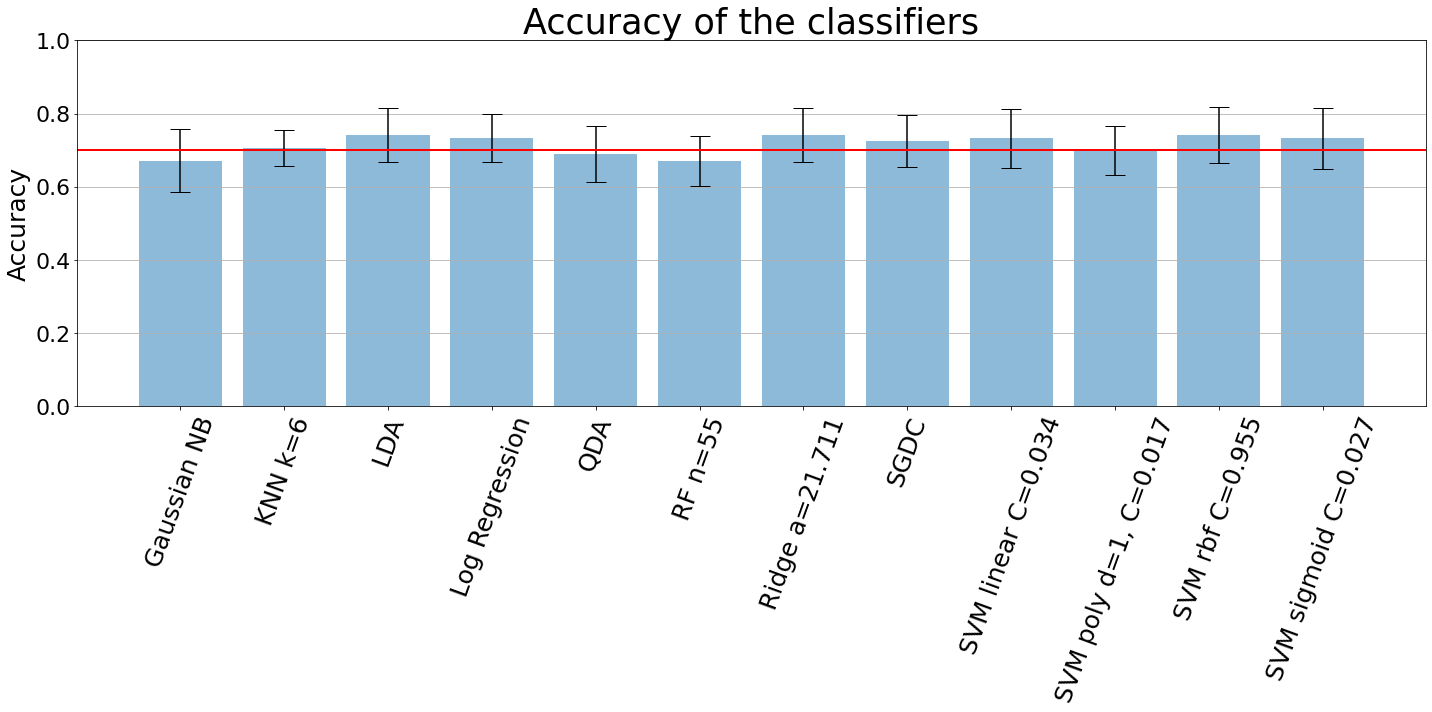

In [0]:
# For each different type of classifier, calculate the mean performance over all folds
performance_grouped = performance_concat.groupby(performance_concat.index)
performance_means = performance_grouped.mean()
performance_se = performance_grouped.std()/np.sqrt(amount_folds)

# Error bars will be set at means +- 1.96 * standard error
performance_ci = 1.96*(performance_se)

print('Mean of performance')
print(performance_means)
print('\nStandard error of performance')
print(performance_se)

# Plot accuracy means with confidence interval as error bars
x_pos = np.arange(len(performance_means))  # the label locations
fig, ax = plt.subplots(figsize=(20,10))
ax.bar(x_pos, performance_means['Accuracy'], width=0.8, yerr=performance_ci['Accuracy'], 
       align='center', alpha=0.5, ecolor='black', capsize=10)
ax.axhline(y=0.7, linewidth=2, color='r')
ax.set_ylabel('Accuracy', fontsize=25)
ax.tick_params(axis="y", labelsize=22)
ax.set_xticks(x_pos)
ax.set_xticklabels(performance_means.index.values, fontsize=25, rotation=70)
ax.set_title('Accuracy of the classifiers', fontsize=35)
ax.yaxis.grid(True)

plt.ylim(0,1)
plt.tight_layout()
plt.show()

##Plot learning curve of final classifier

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)


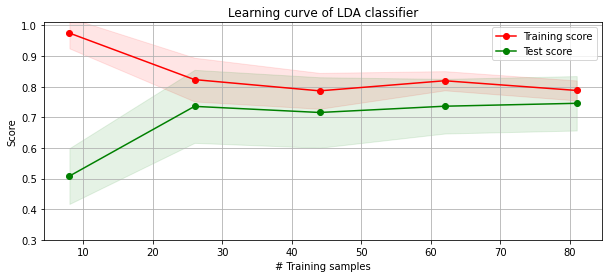

In [117]:
# Choose most optimal classifier
clf_final = clsfs[7]
print(clf_final)

fig = plt.figure(figsize=(10,4))
plt.title('Learning curve of LDA classifier')
plt.ylim(0.3, 1.01)
plt.xlabel("# Training samples")
plt.ylabel("Score")

cv_5fold = model_selection.StratifiedKFold(n_splits=5, shuffle=True)

train_sizes, train_scores, test_scores  = model_selection.learning_curve(
    clf_final, feat_design_pca, label_design, cv=cv_5fold) # Naar kijken, split nl zelf in training- en testset
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot learning curve
plt.grid()
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                        train_scores_mean + train_scores_std, alpha=0.1,color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                        test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Test score")
plt.legend(loc="best")